# Gaussian Mixture Models

#### Machine Learning for Quantitative Finance, Joerg Kienitz, joerg.kienitz@mrig.de

V1.2 - June 2025

This notebook serves as an illustration of the method of support vector machines for classification and regression.

This and any accompanying material are being provided solely for information and general illustrative
purposes. The author will not be responsible for the consequences of reliance upon any information contained in or
derived from the presentation or for any omission of information therefrom and hereby excludes all liability for loss
or damage (including, without limitation, direct, indirect, foreseeable, or consequential loss or damage and
including loss or profit and even if advised of the possibility of such damages or if such damages were foreseeable)
that may be incurred or suffered by any person in connection with the presentation, including (without limitation)
for the consequences of reliance upon any results derived therefrom or any error or omission whether negligent or
not. No representation or warranty is made or given by the author that the presentation or any content thereof will
be error free, updated, complete or that inaccuracies, errors or defects will be corrected.

The views are solely that of the authors and not of any affiliate institution. The Chatham House rules apply.
The presentation may not be reproduced in whole or part or delivered to any other person without prior permission
of the author.


The notebook must not be distributed.

In [1]:
# numerical library
import numpy as np

# methods used
from sklearn.mixture import GaussianMixture  # GMM implementation of Skikit Learn
from sklearn.cluster import KMeans           # as basic clasifier
from scipy.stats import multivariate_normal
from sklearn.metrics import pairwise_distances_argmin

# other
from scipy.spatial.distance import cdist

# creating data
from sklearn.datasets import make_blobs

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.colors import ListedColormap

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# colormap
cmap = ListedColormap(["#22334D" , "#3DA7CA", "#D24E42", "#A2BF83"])

In [2]:
# Generate some data
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

The k-means algorithm is designed to find a pre-determined number of clusters within an unlabeled multi-dimensional dataset. This is done by exploiting a simple concept of determining the optimal clustering:

1. Select k random points as initial centroids
2. Count distances between points in dataset and centroids
3. Assign each point to closest centroid
4. Find mean or each group of points and set it as new centroids
5. Check if centroids moved more then some threshold $\epsilon$ 

No  - repeat steps 2-5,
Yes - algorithm covered, we found k centroids for given data
 

The "cluster center" is the arithmetic mean of the distance of all the points belonging to the cluster.
Each point is closer to its own cluster center than to other cluster centers.
These are the underlying assumptions of the k-means algorithm. 

### k-means, resp. Lloyd's algorithm

<b>Input:</b> dataset $x \in \mathbb{R}^{N \times m}$, a number $K \in \mathbb{N}$ of cluster<br>

<b>Output:</b> cluster centroids $\mu_1, \ldots, \mu_k$, assignments for the clusters $c^{(1)}, \ldots, c^{(N)}$<br>


randomly initialize $K$ cluster centroids $\mu_1, \ldots, \mu_K \in \mathbb{R}^n$<br>
Repeat until convergence:

- For $i=1, \ldots, N$ - this is the Cluster assignment step</li>
   - $c^{(i)} :=$ index of centroid closest to $x^{(i)}$</li></ul>
    - For $k=1, \ldots, K$ - move the centroid</li>
        - $\mu_k :=$ average of points assigned to cluster $k$</li></ul>
        - Check the cost function $J$ </li>


Let $x = (x_1, \ldots, x_N)$, $x_i \in \mathbb{R}^m$, be an unlabeled data set, let $C:=\{\mu_1, \ldots, \mu_K\} \in \mathbb{R}^n$ be called *centroids*, and assume that any $x_i$ is assigned an index $c_i \in \{1, \ldots, K\}$. 

Then
$$J(c_1, \ldots, c_N, \mu_1, \ldots, \mu_K) := \frac{1}{N} \sum_{i=1}^{N}{\|x_i - \mu_{c_i}\|^2}$$

is the cost function for $K$-means. The optimization of the cost function is trying to approximate <b>Inertia</b>. This measure is given by:
        
$$\sum_{i=0}^N \min_{\mu_j: j=1,\ldots,K} \|x_i-\mu_j\|^2$$

**Inertia** measures how well a dataset was clustered by an algorithm, e.g. K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. It can be seen as a measure of how internally coherent clusters are. 


A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.

To find the optimal $K$ for a dataset, use the **Elbow method** which was describe in the introduction. This finds the point where the decrease in inertia begins to slow down.

It suffers from various drawbacks:<br>

<ul>
    <li> Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.</li>
    <li> Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.</li>
</ul>

We use k-means for creating starting values for GMM

In [3]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
# this function plots the results from k means clustering
# it plots a circle using the (euclidean) distance from the centers

    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=cmap, zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0) # call k means from SciKit learn
plot_kmeans(kmeans, X)                        # plot the results, i.e. the clusters


In [5]:
# different data set
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

k-Means is fuelled by Expectation-Maximization - a standard and beautiful method for optimization!

We consider the basics here

In [6]:


X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(420)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap=cmap,
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap=cmap, s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

Text(0.98, 0.98, 'Final Clustering')

# Gaussian Mixture Models

In [7]:
# now we apply the Gaussian Mixtures
gmm = GaussianMixture(n_components=4).fit(X)
labels_gmm = gmm.predict(X)
labels_kmeans = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels_gmm, s=40, cmap=cmap);
plt.scatter(X[:, 0], X[:, 1], marker = 'x', c=labels_kmeans);
plt.title('Classification GMM and k-Means');

In [8]:
# GMM does not quantify in terms of distances but probabilities!
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.002 0.972 0.026]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.999 0.001]]


In [9]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels_gmm, cmap=cmap, s=size);

In [10]:
gmm = GaussianMixture(n_components=4).fit(X_stretched)
labels_stretched = gmm.predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_stretched , s=40, cmap=cmap);

In [11]:
probs = gmm.predict_proba(X_stretched)
print(probs[:5].round(3))

[[0.    0.426 0.    0.574]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


In [12]:
# function for plotting GMM

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=cmap, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [13]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Since we are working with Gaussian distributions, we have the freedom to choose the covariance structure!

1. full
2. diag 
3. spherical

Let us consider some examples

In [14]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

In [15]:
# Now, using all different covariance structures


fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.05)

rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

for i, cov_type in enumerate(['diag', 'spherical', 'full']):
    model = GaussianMixture(1, covariance_type=cov_type).fit(X)
    ax[i].axis('equal')
    ax[i].scatter(X[:, 0], X[:, 1], alpha=0.5, color="#22334D")
    ax[i].set_xlim(-3, 3)
    ax[i].set_title('covariance_type="{0}"'.format(cov_type),
                    size=14, family='monospace')
    
    if cov_type == 'diag':
        covariance = np.array([[model.covariances_[0][0], 0], [0, model.covariances_[0][1]]])
    elif cov_type == 'spherical':
        covariance = np.array([[model.covariances_[0], 0], [0, model.covariances_[0]]])
    else:
        covariance = np.array([[model.covariances_[0][0][0], model.covariances_[0][0][1]], [model.covariances_[0][1][0], model.covariances_[0][1][1]]])
    print('mean', model.means_[0], cov_type, covariance)        
    draw_ellipse(model.means_[0], covariance, ax[i], alpha=0.2)
    #fig.savefig('figures/05.12-covariance-type.png')

mean [0.04322586 0.00972214] diag [[0.80780603 0.        ]
 [0.         0.16027536]]
mean [0.04322586 0.00972214] spherical [[0.48404069 0.        ]
 [0.         0.48404069]]
mean [0.04322586 0.00972214] full [[0.80780603 0.207294  ]
 [0.207294   0.16027536]]


Since we wish to dig deeper into the applications of Gaussian Mixture Models we need to delve into the theory we need to consider:

<b> The Gaussian Distribution</b>
- pdf/cdf in 1 and n dimensions
- marginals and conditionals

We have created a dedicated jupyter notebook illustrating the Gaussian Distribution (Gauss.ipynb)!

<b> Gaussian Mixture Models</b>
- Definition and illustration
- pdf/cdf
- marginals and conditionals

<b> Simulating from a Gaussian Mixture Model</b>
- Using results from the Gaussian 

<b> How to get the parameters?</b>
- k-means
- Expectation-Maximization algorithm

<b> Regression GMMR</b>
The idea is that we use GMM not for classification but regression!


## Gaussian Mixture Models

Let $K\in\mathbb{N}$, and $Z_k$, $k=1,\ldots,K$ be $d$-dimensional random variables, $Z_k\sim\mathcal{N}(\mu_k,\Sigma_k)$, with densities $n_{Z_k}$

Definition:
Consider the <it>Gaussian Mean Mixture</it> $Z$ determined by the density
$$
p_Z = \sum_{k=1}^{K} \pi_k n_{Z_k}, \, \pi_k >0, \,\sum_{k=1}^K \pi_k = 1.
$$

$\pi_k$ - <it>mixing weights</it>, GMM(K)- $K$ component GMM with
$$
\mu_Z = \sum_{k=1}^K \pi_k \mu_{k}, \, \mathbb{V}(Z) = \sum_{k,j=1}^K\pi_k\pi_j(\mathbb{E}[Z_kZ_j] - \mathbb{E}[Z_k]\mathbb{E}[Z_j])
$$

We call a single component a <it>Gaussian Principal Component</it>. The <it>LGMM</it> is simply the lognormal mixture model, i.e. $\exp(\cdot)$ is Gaussian. LGMM are common in Quantitative Finance and have long been applied for volatility modelling.

Let us code the density of the Gaussian Mixture Model

In [16]:
def gmm(value, pis, means, variances):
# density of a Gaussian Mixture Model
    density = np.zeros(value.shape)
    for i, mean in enumerate(means):
        density += pis[i]/np.sqrt(2*np.pi)/variances[i] * np.exp(-1/(2*variances[i]**2)*(value-mean)**2)
    return density

In [17]:
def plot_1D_gaussian_mixture_model(means,variances,pis, lb = -10, ub = 10, nstep = 1000, sample_variates=True, nsamples = 1000):
   
    
    
    if sample_variates:
        samples = []
        uniforms = np.random.uniform(0,1,nsamples)
        acc_pis = np.cumsum(pis)
        
        for i in range(nsamples):
            # sample uniform
            u = uniforms[i]
        
            # select gaussian
            if u <= acc_pis[0]:
                k  = 0
            else:
                k = np.max(np.where(acc_pis <= u)[0])+1
    
            selected_mu = means[k]
            selected_cov = variances[k]
                
            x_multi = np.random.normal(selected_mu, selected_cov)
        
            samples.append(x_multi)

    x_cal = np.linspace(lb, ub, nstep)
    y_cal = gmm(x_cal, pis, means, variances)

    fig = plt.figure()
    
    if sample_variates:
        n, bins, patches = plt.hist(x=np.array(samples), bins='auto', color="#22334D",
                                alpha=0.7, rwidth=0.85, label='sampled gmm', density=True)
    plt.plot(x_cal, y_cal, label='gmm', color="#3DA7CA")
    plt.title('1D Gaussian Mixture Model')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.legend()
    plt.show()
    # fig.savefig('../../Portfolio/1D_gmm_sample.png')

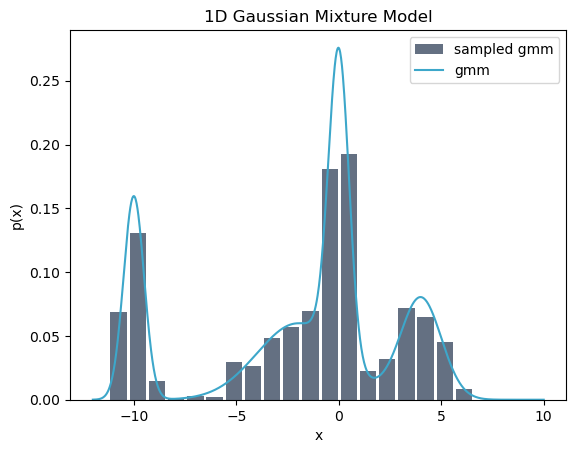

In [35]:
# plot samples from 1D gaussian mixture mdodel
means_1d = [-10,-2, 4, 0]
variances_1d = [.5,2,1,.5]
weights_1d = [0.2, 0.3, 0.2, 0.3]

plot_1D_gaussian_mixture_model(means_1d, variances_1d,weights_1d, lb=-12,ub=10)

In [25]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [26]:
def plot_2d_gmm(means,variances,pis, sample_variates = True, nsamples = 1000, heat = False):
    
    dim = np.shape(np.atleast_2d(variances).T)[-1]
    
    # analytic
    X, Y = np.meshgrid(np.linspace(-5,5,100), np.linspace(-5,5,200))

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = 0
    for i in range(dim):
        Z = Z + pis[i] * multivariate_gaussian(pos,np.asarray(means[i]), np.asarray(variances[i]))
        
   
    # sampling
    if sample_variates:
        out = np.asarray(sim_nD_gaussian_mixture_model(means,variances,pis,nsamples))
    
        xedges = np.linspace(-5,5,20)
        yedges = np.linspace(-5,5,20)
      
        H, xedges, yedges = np.histogram2d(out[:,0], out[:,1], bins=(xedges, yedges), density = True)
        H = H.T
    
    fig = plt.figure(figsize = (10,10))
    
    if sample_variates:
        ax = fig.add_subplot(1,2,1,projection='3d', title='Analytic')
    else:
        ax = fig.add_subplot(1,1,1, projection='3d', title = 'Analytic')
        
    ax.plot_surface(X, Y, Z, linewidth=1, antialiased=True,
                cmap=cmap)
    
    
    if sample_variates:
    
        if heat:
            # 2d heatmap
            #fig = plt.figure()
            ax = fig.add_subplot(1,2,2,title = 'Heat Map')
            #ax1 = fig.add_subplot(131, title='Heat Map')
            ax.imshow(H, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        else:
            # 3d histogram
            #ax = fig.add_subplot(1,2,2,projection='3d', title = "Histogram")
            # Construct arrays for the anchor positions of the 16 bars.
            xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
            xpos = xpos.ravel()
            ypos = ypos.ravel()
            zpos = 0

            # Construct arrays with the dimensions for the 16 bars.
            dx = dy = 0.5 * np.ones_like(zpos)
            dz = (H.T).ravel()

            ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha = 0.1)
            ax = fig.add_subplot(1,2,2,projection='3d', title = "Histogram")
            ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    plt.show()

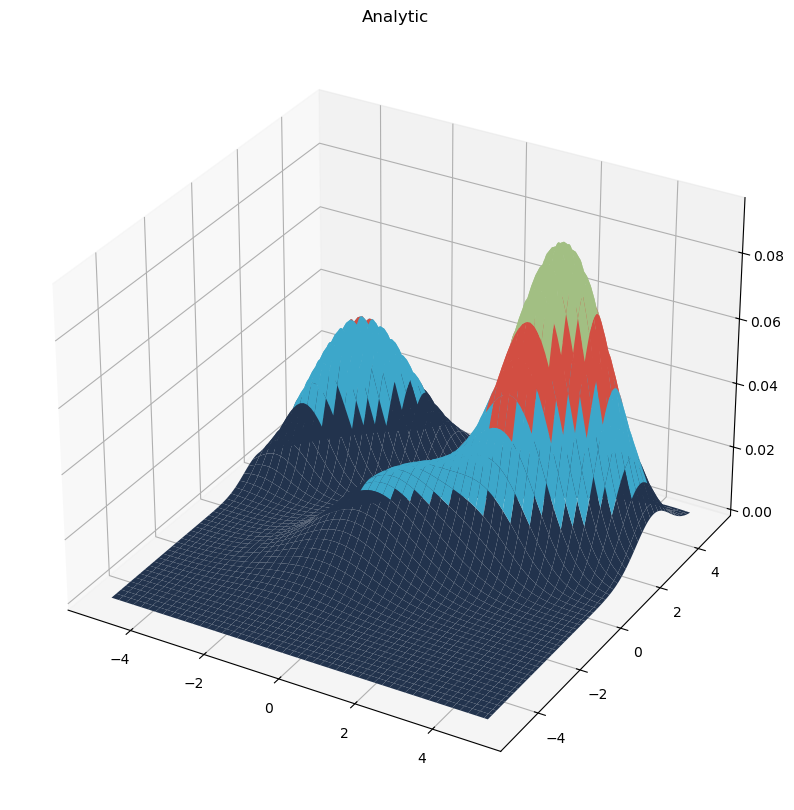

In [27]:
means_2d = [[-3,3], [0, 0], [3, 2]]
variances_2d = [[[1,.75],[.75,1]], [[2,1],[1,2]], [[1,.5],[.5,1]]]
weights_2d = [0.2, 0.3, 0.5]

plot_2d_gmm(means_2d, variances_2d, weights_2d,False,30000,False)

## Gaussian Mixture Regression

For Gaussian Mixture Regression we need to fit a Gaussian Mixture Model. The training data consists of the inputs and the labels, i.e. the data is at least 2 dimensional.

Of course it could be any dimension $\geq 2$.

Once $\pi_k$, $\mu_k$ and $\Sigma_k$, $k=1,\ldots,K$, are fixed, the conditional distribution is given analytically. Let $Z=(Z_1,\ldots,Z_m,Z_{m+1},\ldots,Z_{m+n})^\top$, with $m+n=d$, $Z_{GMM}\sim \mathcal{N}_n(\mu_{Z_{GMM}},\Sigma_{Z_{GMM}})$. 

We denote the realizations by $X$ and the labels by $Y$. We set $Z_{GMM} = (Y,X)^\top$ with $m$-, resp. $n$-dimensional Gaussians $Y=(Z_1,\ldots,Z_m)^\top$ and $X=(Z_{m+1},\ldots,Z_{m+n})^\top$ the conditionals, $Y|X$ and marginals for $Y$ and $X$ are available in closed form, with
$$
\mu_{Z_{GMM}} = \left(\begin{array}{c}
\mu_{Y}\\
\mu_{X}
\end{array}\right)\,
\Sigma_{Z_{GMM}} = \left(\begin{array}{cc}
\Sigma_{YY} & \Sigma_{YX}\\
\Sigma_{XY} & \Sigma_{XX}
\end{array}\right).
$$

Taking $Y$ for instance and by denoting $p_z(x,y)$ the conditional density with regard to $Z$,
\begin{align}
p_{Y}(y) &= \int p_Z(y,x)dx \sim \mathcal{N}_m(\mu_{Y}, \Sigma_{YY}),\\
p_{Y|X=x}(y) &= \frac{p_Z(y,x)}{\int p_Z(y,x) dx} \sim \mathcal{N}_n\left(\mu_{Y|X}, \Sigma_{Y|X}\right)
\end{align}
and the means, resp. variances for the conditional distribution are given by

\begin{align}
\mu_{Y|X} &= \mu_{Y} + \Sigma_{YX}\Sigma_{XX}^{-1}(X - \mu_{X}),\\
\Sigma_{Y|X} &=\Sigma_{YY} - \Sigma_{YX}\Sigma_{XX}^{-1}\Sigma_{XY}.
\end{align}

Using these results for each single component $k=1,\ldots,K$ of GMM(K) we have

$$
p_{k, Y\mid X=x}(y) = \frac{n_k(y,x)}{\int n_k(y,x)dx} \sim \mathcal{N}_n\left(\mu_{k,Y|X}, \Sigma_{k,Y|X}\right)
$$
and for the conditional distribution of GMM(K):

$$
p_{Y|X} = \sum_{k=1}^K \tilde{\pi}_kn_{k,Y|X},\quad
\tilde{\pi}_k  \sim \frac{\pi_k\mathcal{N}_m(\mu_{k,X},\Sigma_{k,XX})}{\sum_l \pi_l \mathcal{N}_m(\mu_{l,X},\Sigma_{l,XX})}.
$$


Crucial observations:
1. Conditional and marginal distributions are readily available
2. Conditional Distributions are again GMM
3. The regression can be done by fitting a GMM using $(x,y)$ values for training and then using the conditional distribution and the expressions for expectation and variance for new data.

### Application to option pricing

We have a dedicated workbook for the application of GMM to option pricing and hedging!

### Simulating from Gaussian Mixture Models

<b>Stochastic Simulation Algorithm</b>

Using the notation from above, the simulation from a given GMM with $K$ components is facilitated using the following algorithm:

1. Compute the vector $v=(v_1,\ldots,v_K)$, $v_i=\sum_{j=1}^i\pi_j$, $i=1,\ldots,K$
2. Sample $u\sim\mathcal{U}(0,1)$
3. Find the mixture component according to $u$.
$$
k:=\max_i\{ v_i\leq u\}
$$
4. Sample $x\sim\mathcal{N}_k(\mu_k,\Sigma_k)$

The algorithm accommodates conditional sampling using the corresponding expressions for the conditional mean, covariance and weights.

As the conditional distribution is again GMM with $K$ components. 

The only thing that is different is that the conditional means, covariances and weights are functions of the variable to be conditioned on.

We stress the interpretation of $\mu_k$, $k=1,\ldots,K$ as the Gaussian Principal Components (GPC) representing the principal shapes of the state variables. Together with the weights this is analogous to eigenvectors/eigenvalues for principal component analysis.


In [28]:
def sim_nD_gaussian_mixture_model(means,variances,pis,nsamples = 1000):
    # determine the dimensionality of the Gaussians
    dim = np.shape(np.atleast_2d(variances).T)[1]
    
    # accumulate the weights
    acc_pis = np.cumsum(pis)
    
    samples = []
    uniforms = np.random.uniform(0,1,nsamples)
    for i in range(nsamples):
        # sample uniform
        u = uniforms[i]
        
        # select gaussian
        if u <= acc_pis[0]:
            k  = 0
        else:
            k = np.max(np.where(acc_pis < u)[0])+1
    
        selected_mu = means[k]
        selected_cov = variances[k]
        
        if dim == 1:
            x_multi = np.random.normal(selected_mu, selected_cov)
        else:
            x_multi = np.random.multivariate_normal(selected_mu, selected_cov)
        samples.append(x_multi)

    return samples

# need to assume at least 2d Gaussians
def simulate_gmm_conditional(means, variances, weights, y, cond_dim = 1, nsamples = 1000):
    # determine the dimensionality of the Gaussians
    dim = np.shape(np.atleast_2d(variances).T)[1]
    ngmm = np.shape(np.atleast_2d(variances).T)[-1]
    
    gmm_cond = GMM_Conditional(means=means,
                               covariances=variances,
                               weights=weights,
                               n_components=ngmm,
                               D1=cond_dim, D2=dim-cond_dim)
        
    samples = []
    
    uniforms = np.random.uniform(0,1,nsamples)
    mu, cov, weights = gmm_cond.par_x1_cond_x2(y)
    
    acc_weights = np.cumsum(weights)           
      
    for i in range(nsamples):
        # sample uniform
        u = uniforms[i]
        
        # select gaussian
        if u <= acc_weights[0]:
            k  = 0
        else:
            k = np.max(np.where(acc_weights <= u)[0])+1
        
        selected_mu = mu[k]
        selected_cov = cov[k]
        
        if cond_dim == 1:
            x_multi =  np.random.normal(selected_mu, selected_cov)
        else:
            x_multi = np.random.multivariate_normal(selected_mu, selected_cov)
        
        samples.append(x_multi)

    return samples 


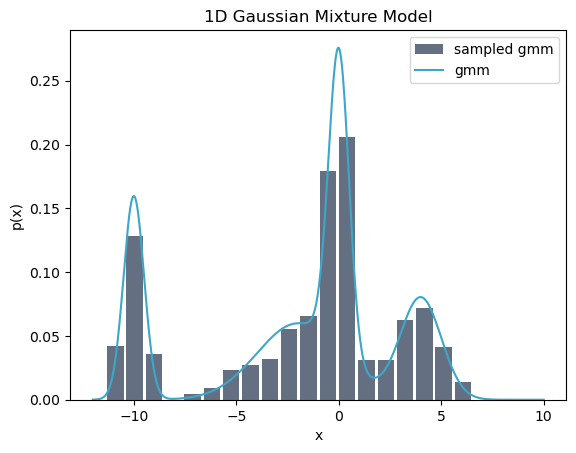

In [33]:
plot_1D_gaussian_mixture_model(means_1d, variances_1d,weights_1d, lb=-12)

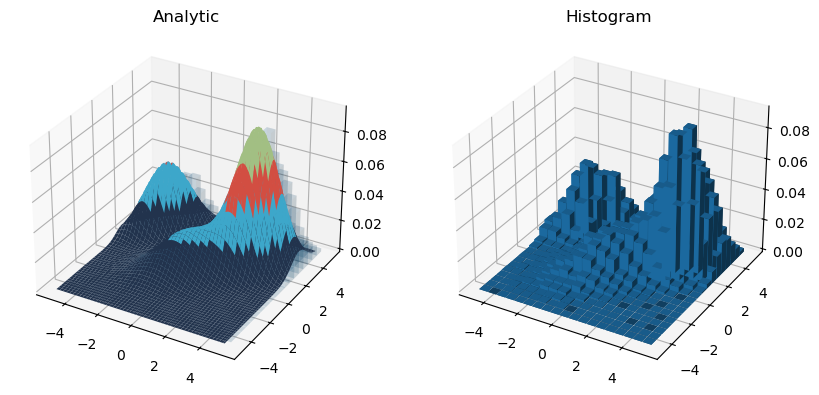

In [30]:
plot_2d_gmm(means_2d, variances_2d, weights_2d,True,30000,False)

We have dedicated workbooks for illustrating the use of GMM for data generation and simulation.

In [26]:
'''
Working with conditional GMM we need to code the corresponding formulas.

A source that can be used instead of coding from scratch:
https://github.com/tmcclintock/ConditionalGMM
 
Tom McClintock
 
condGMM.py
(condGMM.py uses MVNorm.py)
'''

from condGMM import *



In [27]:
means_3d = [[-3,3,3], [0, 0, 0], [3, 2, 2]]
variances_3d = [[[ 1.35946017e-03,  1.99596001e-04,  2.55094611e-04],
        [ 1.99596001e-04,  3.32917614e-03,  2.61702286e-03],
        [ 2.55094611e-04,  2.61702286e-03,  2.65381226e-03]], [[ 5.17979516e-03, -9.72587317e-05, -1.55786295e-04],
        [-9.72587317e-05,  4.18183796e-03,  2.03605046e-03],
        [-1.55786295e-04,  2.03605046e-03,  4.78367600e-03]], [[ 1.07407174e-03, -6.11391757e-05, -4.87452301e-05],
        [-6.11391757e-05,  1.09940378e-03,  1.05219372e-03],
        [-4.87452301e-05,  1.05219372e-03,  1.06998816e-03]]]
weights_3d = [0.2, 0.3, 0.5]

np.shape(np.atleast_2d(variances_3d).T)[1]

3

In [28]:
ngmm = np.shape(np.atleast_2d(np.asarray(variances_3d)).T)[-1]

gmm_cond = GMM_Conditional(means=np.asarray(means_3d),
                               covariances=np.asarray(variances_3d),
                               weights=np.asarray(weights_3d),
                               n_components=ngmm,
                               D1=1, D2=2)

y = np.asarray([1,2])
m,s,w = gmm_cond.par_x1_cond_x2(y)

In [29]:
mu_cond = np.asarray([m[0][0], m[1][0], m[2][0]])
sig_cond = np.asarray([s[0][0][0], s[1][0][0], s[2][0][0]])
w_cond = w

In [30]:
out_1d = simulate_gmm_conditional(np.asarray(means_3d), np.asarray(variances_3d), np.asarray(weights_3d), np.asarray([1,2]), cond_dim = 1, nsamples = 1000)
out_2d = simulate_gmm_conditional(np.asarray(means_3d), np.asarray(variances_3d), np.asarray(weights_3d), np.asarray([1]), cond_dim = 2, nsamples = 1000)

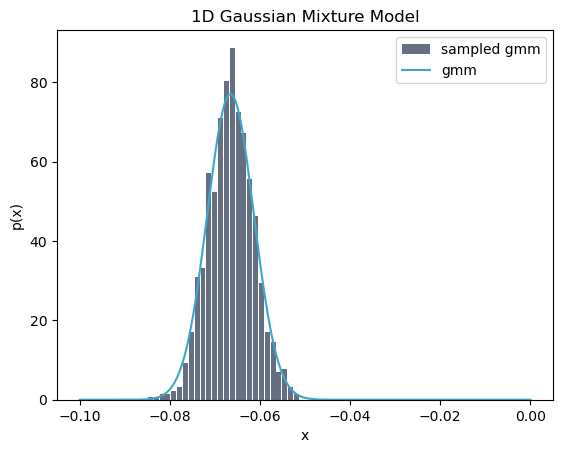

(-0.1, 0.0)

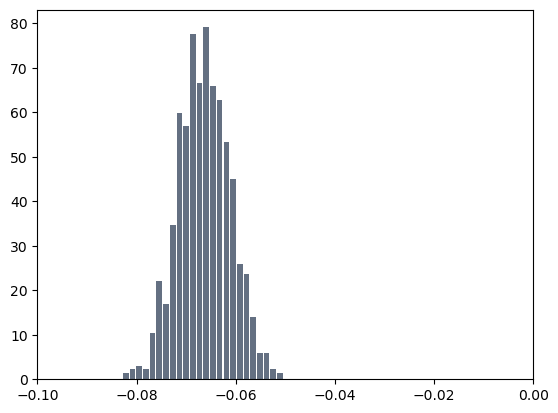

In [31]:
plot_1D_gaussian_mixture_model(mu_cond, sig_cond,w_cond,-.1,0,200,True, 1000)

n, bins, patches = plt.hist(x=np.asarray(out_1d)[:,0,0], bins='auto', color="#22334D",
                                alpha=0.7, rwidth=0.85, label='sampled gmm', density=True)
plt.xlim([-.1,0])

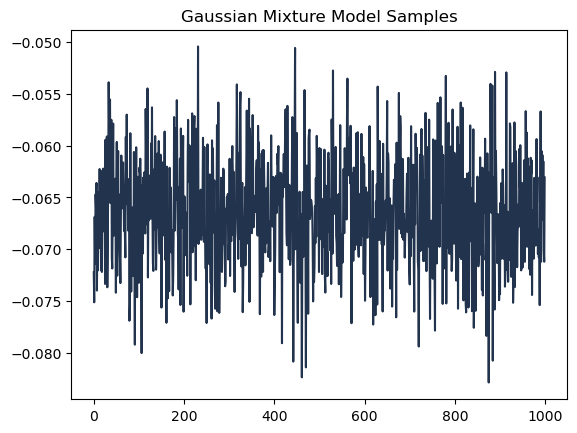

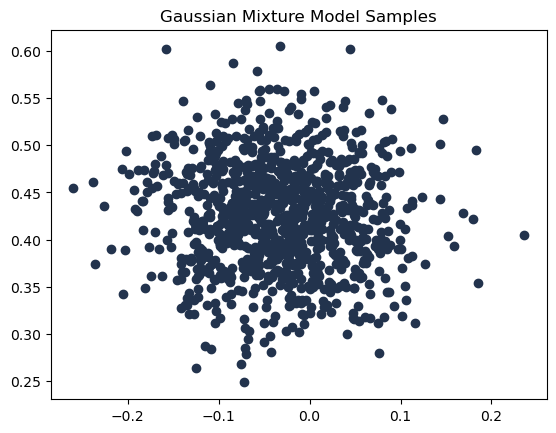

In [32]:
fig = plt.figure()
samples = np.asarray(out_1d)[:,0,0]
plt.plot(samples, color="#22334D")
plt.title('Gaussian Mixture Model Samples')
plt.show()

fig = plt.figure()
samples = np.array(out_2d)
plt.scatter(samples[:,0], samples[:,1], color="#22334D")
plt.title('Gaussian Mixture Model Samples')
plt.show()

## Parameter Estimation

There are several ways to deduce the parameters for fitting the GMM model. The most well known one is, as for the k-Means, the <b>Expectation Maximization</b> (EM) algorithm. 

Let $\mathcal{N}_n(\mu,\Sigma)$ denote the d-dimensional probability distribution function for a normal random variable with mean vector $\mu$ and covariance matrix $\Sigma$. The marginal distribution of $X_i$ is
$$
P(X_i = x) = \sum_{k=1}^K P(Z_i = k) P(X_i=x | Z_i = k) = \sum_{k=1}^K \pi_k \mathcal{N}_n(x; \mu_k, \Sigma_k)
$$

Similarly, the joint probability of observations $x_1,\ldots, x_N$ is
$$
P(X_1=x_1,\ldots,X_N=x_N) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}_n(x_n; \mu_k, \Sigma_k)
$$

The EM algorithm aims at obtaining the Maximum Likelihood Estimates (MLEs) of $\pi_k$, $\mu_k$ and $\Sigma_k$ given a set of observations $\{x_1,\ldots,x_N\}$. 

### Maximum Likelihood Estimate for the univariate Gaussian Model

To begin with, we can find the MLE for the mean of the univariate Gaussian model: 
\begin{align}
l(\mu) &= \prod_{n=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp{-\frac{(x_n-\mu)^2}{2\sigma^2}} \nonumber\\
\Rightarrow \log l(\mu) &= \sum_{n=1}^N \left[ \log \left (\frac{1}{\sqrt{2\pi\sigma^2}} \right )  - \frac{(x_n-\mu)^2}{2\sigma^2} \right] \nonumber\\
\Rightarrow \frac{d}{d\mu}\log l(\mu) &= \sum_{n=1}^N \frac{x_n - \mu}{\sigma^2}\nonumber
\end{align}

By setting the last result equal to zero and solving for $\mu$, we obtain $\hat{\mu}=\frac{1}{N}\sum_{n=1}^N x_n$ as our MLE estimate for $\mu$.

### Maximum Likelihood Estimate for the Gaussian Mixture Model

Now, we can apply the same idea and find the MLEs for the GMM model with unknown parameters $\theta = \{\pi_1,\ldots,\pi_K,\mu_1,\ldots, \mu_K,\Sigma_1,\ldots,\Sigma_K\}$ where we assume the number of components $K$ to be given.  The (log-)likelihood function for the GMM is

$$l(\theta) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}_n(x_n;\mu_k, \Sigma_k)=\prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}_n(x_n;\mu_k, \Sigma_k)$$
$$\Rightarrow \log l(\theta) = \sum_{n=1}^N \log \left( \sum_{k=1}^K \pi_k \mathcal{N}_n(x_n;\mu_k, \Sigma_k)\right)$$

A general problem is that the summation $ \sum_{k=1}^K \ldots$ is inside the log function. 
To resolve this, we can introduce a new distribution $q_k(x_n,\theta)$ for each component $k=1,\ldots,K$
$$\log l(\theta) = \sum_{n=1}^N \log \left( \sum_{k=1}^K q_k(x_n,\theta) \frac{p(x_n,\theta)}{q_k(x_n,\theta)}\right) $$
where $p(x_n,\theta) \sim \pi_k \mathcal{N}_n(x_n;\mu_k, \Sigma_k)$. 
Since the $\log$ function is a concave function we can apply Jensen's inequality and swap the summation
\begin{align}
\log l(\theta) = \sum_{n=1}^N \log \left( \sum_{k=1}^K q_k(x_n,\theta) \frac{p(x_n,z_n=k,\theta)}{q_k(x_n,\theta)}\right) \geq \sum_{n=1}^N \sum_{k=1}^K  q_k(x_n,\theta) \log \left(\frac{p(x_n, z_n=k,\theta)}{q_k(x_n,\theta)}\right)
\end{align}
Note that in the case where the distributions $q_k(x_n, \theta)$ are known, the maximum log-likelihood problem would be equal to finding the maximum lower bound in (1). 

### Estimating the posterior probabilities

Recall that we can evaluate the log-likelihood for any fixed choice of $\theta=\{\mu_1,\ldots \mu_k, \sigma_1, \ldots \sigma_k, \pi_1, \ldots \pi_k\}$
$$\log l(\theta) \geq \sum_{n=1}^N \sum_{k=1}^K  q_k(x_n, \theta) \log \left(\frac{p(x_n, z_n=k,\theta)}{q_k(x_n)}\right)$$
So we can fix $\theta=\theta_\gamma$ where $\gamma$ would be the current step in an iteration scheme and $\theta_\gamma$ is the current choice of parameters. 
Let's consider the posterior choice $q_k(x_n,\theta_\gamma)=p(z_n=k|x_n,\theta_\gamma)$ which turns the inequality on the r.h.s. of (1) into the equality. By ignoring the part that doesn't depend on $\theta$, we can now define and optimize a function $Q(\theta)$ 
$$
Q(\theta)=\sum_{n=1}^N \sum_{k=1}^K  p(z_n=k|x_n,\theta) \log \left(p(x_n,z_n=k, \theta)\right)=  \mathbb{E}_{p(z_n|x_n,\theta_\gamma)} \log \left(p(x_n,z_n, \theta)\right)
$$
that lowers the bound for the inequality (1) and is equal at our current guess $\theta$. By iterating between calculating the expectation and then maximizing the log-likelihood the lower bound will always improve (until convergence).  

In order to see how that scheme works for the GMM model, we observe that the expected log-likelihood becomes a weighted average of $k$ fitted Gaussians with weights $\gamma_{z_n}(k)=p(z_n=k|x_n,\theta)$
\begin{align}
\mathbb{E}_{p(z_n|x_n)}\left[\sum_{n=1}^N \log (p(x_n,z_n,\theta))\right] &= \sum_{n=1}^N \sum_{k=1}^K \left[\gamma_{z_n}(k)\log(p(z_n=k,\theta))+\log(p({x_n|z_{n}=k,\theta}))\right] \nonumber\\
&\sim \sum_{n=1}^N \sum_{k=1}^K \gamma_{z_n}(k)\left[\log(\pi_k)+\log (\mathcal{N}_n(x_n; \mu_k, \Sigma_k))\right]\nonumber
\end{align}
Solving for $\mu_k$ annd $\Sigma_k$ is like fitting $k$ separate Gaussians with weights $\gamma_{z_n}$, so the solution $\hat{\mu}_k$ is (cf. univariate case)
$$
\hat{\mu_k} = \frac{1}{N_k}\sum\limits_{n = 1}^{N}\gamma_{z_n}(k)x_n
$$
and similarly,
\begin{align}
&\hat{\sigma}_k^2  {= \frac{1}{N_k}\sum\limits_{n = 1}^{N}\gamma_{z_n}(k)(x_n - \mu_k)(x_n - \mu_k)^T} \nonumber \\
&\hat{\pi}_k  = \frac{N_k}{N}\nonumber
\end{align}
where $N_K=\sum_{n=1}^N \gamma_{z_n}(k)$.

### EM Algorithm

Now, we have everything to apply the EM algorithm: <ul> 
    <li>Initialize $\pi_k$, $\mu_k$, $\Sigma_k$ and evaluate the log likelihood</li>
    Repeat until convergence:
    <li> Expectation step: Evaluate the posterior probabilities $\gamma_{Z}(k)$ using the values $\mu_k$ and $\Sigma_k$</li>
    <li> Maximization step: With $\gamma_{z_n}(k)$ fixed, estimate new parameters $\hat{\mu}_k$, $\hat{\Sigma}_k$ and $\hat{\pi}_k$ by maximizing the log likelihood</li>
</ul>

To see how this works, we consider our own GMM class!

In [33]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = np.random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = np.random.rand(k, 3)
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

To test and illustrate we use some data generation method...

In [34]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [35]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(4, 4))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors, cmap=cmap)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.title(title)
    #plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

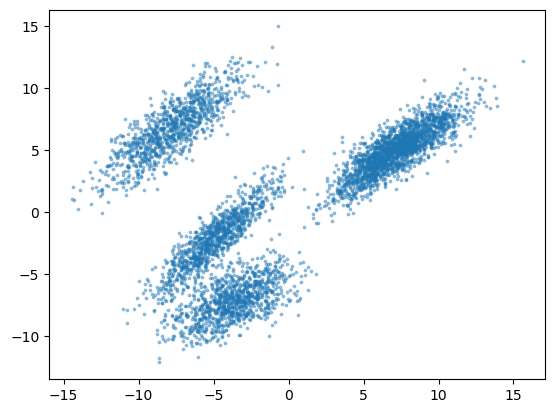

In [36]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=5, dim=2, points_per_cluster=1000)

In [37]:
gmm = GMM(3, 2)

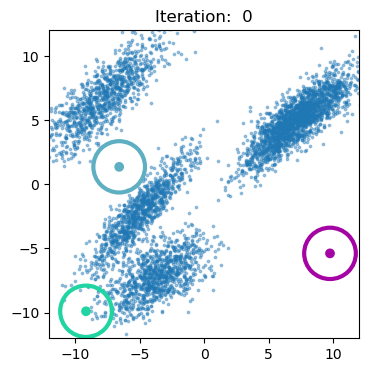

Iteration: 1, log-likelihood: -27031.4208


<Figure size 640x480 with 0 Axes>

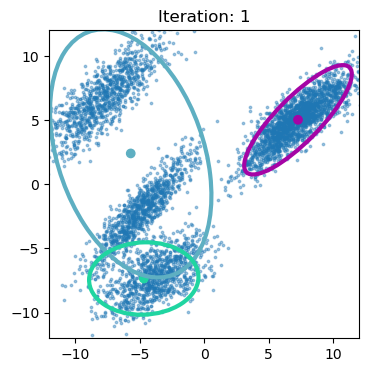

Iteration: 2, log-likelihood: -26875.3064


<Figure size 640x480 with 0 Axes>

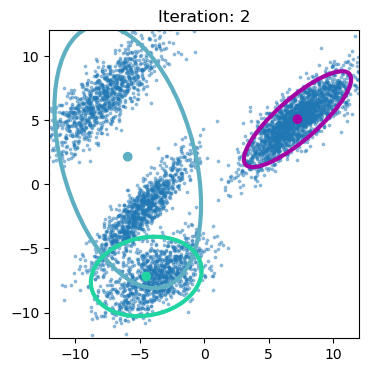

Iteration: 3, log-likelihood: -26861.4896


<Figure size 640x480 with 0 Axes>

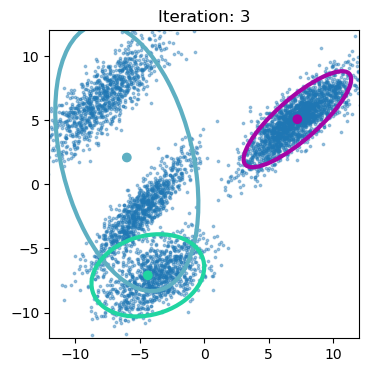

Iteration: 4, log-likelihood: -26857.0245


<Figure size 640x480 with 0 Axes>

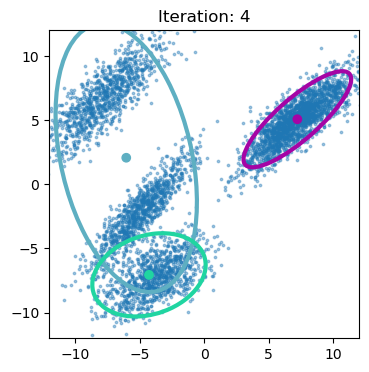

Iteration: 5, log-likelihood: -26854.8909


<Figure size 640x480 with 0 Axes>

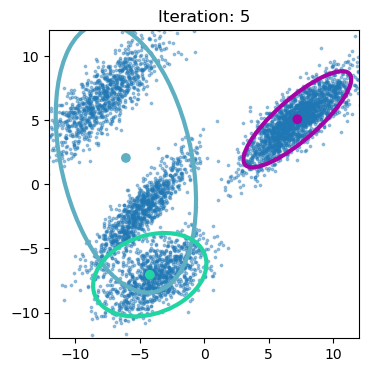

Iteration: 6, log-likelihood: -26853.1724


<Figure size 640x480 with 0 Axes>

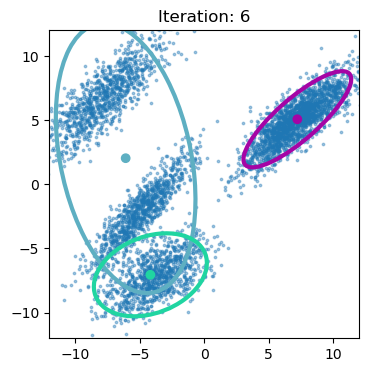

Iteration: 7, log-likelihood: -26851.1770


<Figure size 640x480 with 0 Axes>

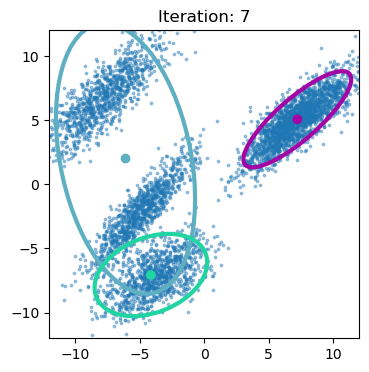

Iteration: 8, log-likelihood: -26848.5478


<Figure size 640x480 with 0 Axes>

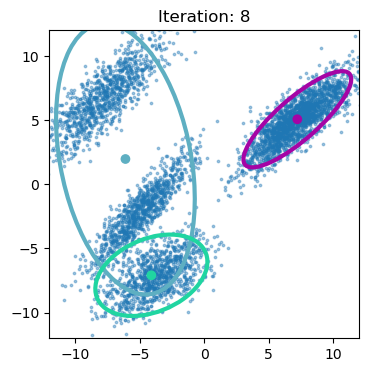

Iteration: 9, log-likelihood: -26845.0094


<Figure size 640x480 with 0 Axes>

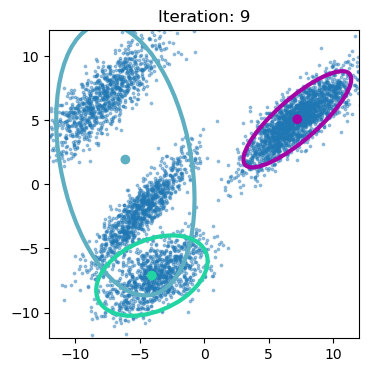

Iteration: 10, log-likelihood: -26840.3211


<Figure size 640x480 with 0 Axes>

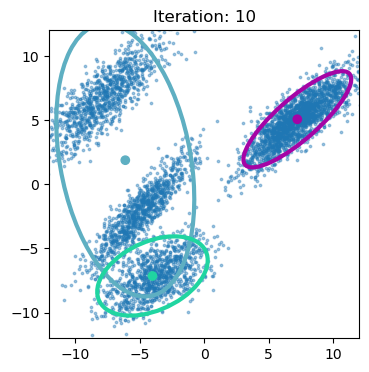

<Figure size 640x480 with 0 Axes>

In [38]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)
num_iters = 10
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

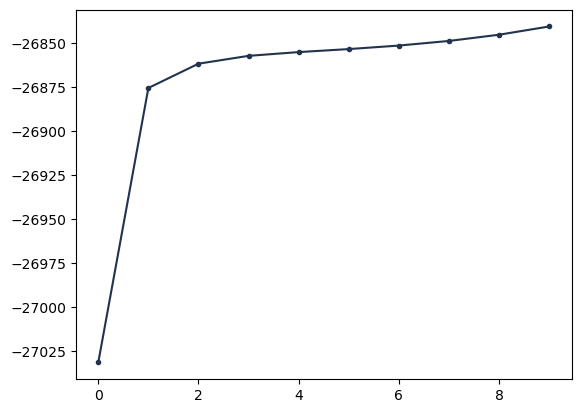

In [39]:
#Plot log-likelihood
plt.plot(log_likelihood[1:], marker='.', color="#22334D")

## Be careful with the number of Gaussian!

In [40]:
def npdf_org(x,mu,sigma):
    return 1./(sigma * np.sqrt(2. * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

In [41]:
from scipy.stats import chi2
def npdf_org_chi(x, df):
    return chi2.pdf(x, df)

In [42]:
mu_org = 0.
sigma_org = 1.
df_org = 5

nruns = 100000
X = np.random.normal(mu_org,sigma_org,nruns).reshape(-1,1)
#X = np.random.chisquare(df_org,nruns).reshape(-1,1)

xvals = np.linspace(-2,2,100)

In [52]:
ngmm = 20
gmm = GaussianMixture(n_components=ngmm).fit(X)
gmm1 = GaussianMixture(n_components = ngmm + 10).fit(X)
density_g = npdf_org(xvals,mu_org,sigma_org)
#density_g = npdf_org_chi(xvals,df_org)

In [53]:
gmm.weights_, gmm.means_.T

(array([0.07204089, 0.04087568, 0.08330666, 0.05662714, 0.01952163,
        0.07111567, 0.0159669 , 0.08590151, 0.05244253, 0.06589938,
        0.0446331 , 0.00991111, 0.087041  , 0.00710193, 0.06254635,
        0.03101037, 0.0808371 , 0.02873425, 0.0034932 , 0.08099362]),
 array([[-0.61658556,  1.45383016,  0.2532974 , -1.09552697, -1.99597588,
          0.69684527,  2.1736755 , -0.17869477,  1.17672045, -0.84565332,
         -1.36672761, -2.38945682,  0.0347778 ,  2.66326069,  0.92605172,
         -1.66007399,  0.47095673,  1.78162393, -2.93247637, -0.39300182]]))

0.07204088783919362 -0.6165855649413797 0.08937309751130432
0.04087567819314082 1.4538301607874096 0.12131720755046413
0.08330665872627825 0.2532973993617924 0.08597634279202863
0.05662714036510043 -1.095526968254703 0.1006514990597758
0.019521626294374504 -1.9959758782470056 0.14588431643608196
0.07111567307300862 0.6968452695143355 0.0906321363587998
0.01596689838754644 2.1736755026143673 0.19434242972096966
0.08590151232146091 -0.17869477217772575 0.08367875919406705
0.05244253395697333 1.1767204460165304 0.10492504600936714
0.06589937708818887 -0.8456533198218701 0.09514201880063433
0.04463309932210621 -1.3667276115425437 0.10970955460787883
0.009911112439278773 -2.3894568217051986 0.19654564809981825
0.08704099534849509 0.03477779636113578 0.08509209931251298
0.007101925455040557 2.6632606917866766 0.3751732689192071
0.0625463465837958 0.9260517192888432 0.09693116486858996
0.031010367031377568 -1.6600739882416025 0.12169563810728982
0.08083710077030673 0.47095672625201024 0.08759

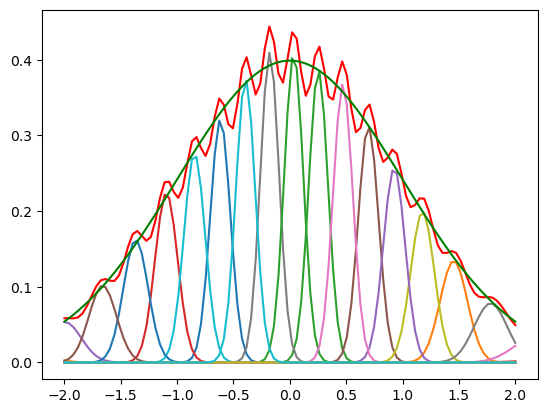

In [54]:
gmm.weights_, gmm.means_, np.sqrt(gmm.covariances_)
density_gmm = np.zeros_like(xvals)


for i in range(0,ngmm):
    w = gmm.weights_[i]
    mu = gmm.means_[i][0]
    sigma = np.sqrt(gmm.covariances_[i][0][0])
    print(w,mu,sigma)
    density = npdf_org(xvals,mu,sigma)
    density_gmm += w * density
    plt.plot(xvals,w * density)
    
plt.plot(xvals,density_gmm,'r')
plt.plot(xvals,density_g,'g')

In [55]:
xx = gmm1.sample(10)[0]
gmm.bic(xx)

np.float64(160.60304270871205)

In probability theory and statistics, the Jensen–Shannon divergence, is a method of measuring the similarity between two probability distributions. 

It is also known as information radius or total divergence to the average. It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. 

The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen–Shannon distance. The similarity between the distributions is greater when the Jensen-Shannon distance is closer to zero.

In [47]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
# Jensen-Shanno divergence
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

In [48]:
gmm_js(gmm,gmm1)

np.float64(0.0010014824566404457)